This notebook builds on the findings from Notebook 2. We saw that demographic features (customerType, investmentCapacity) alone were insufficient to reliably predict investor risk profiles.

Here, we will engineer behavioral features from transaction data (transactions.csv, asset_information.csv) to capture actual investor behavior. The enriched dataset will then be used to improve supervised models.

### Investment transactions README.md

* File name: transactions.csv

* Description: Detailed investment transactions by customers.

* Columns:
    - customerID: Customer identifier.
    - ISIN: Unique International Securities Identification Number (ISIN) of the asset.
    - transactionID: Transaction identifier.
    - transactionType: Transaction type (Buy / Sell).
    - timestamp: Date of the transaction (YYYY-MM-DD format)
    - totalValue: Total monetary value of the transaction (in euros).
    - units: Number of shares traded.
    - channel: Channel over which the customer performed the transaction. Values:
        - Internet Banking
        - Phone Banking
        - Branch
    - marketID: Identifier of the market over which the transaction was performed.


### Asset information README.md

* File name: asset_information.csv

* Description: Detailed information about the assets. NOTE: An asset can appear here several times.

* Columns:
    - ISIN: Unique International Securities Identification Number (ISIN) of the asset.
    - assetName: Name of the asset.
    - assetShortName: Short name of the asset.
    - assetCategory: Category of the asset. Values:
        - Stock
        - Bond
        - MTF (mutual fund)
    - assetSubCategory: Sub-category of the asset. Depends on the main type.
    - marketID: Market where the asset is traded.
    - sector: economic sector of the asset (when available).
    - industry: industry of the asset (when available).
    - timestamp: Last update date.


In [2]:
# Cell 1 — Setup & Imports
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
BASE_DIR = "/content/drive/MyDrive/portfoliai"
RAW_DIR = f"{BASE_DIR}/data/raw"
PROC_DIR = f"{BASE_DIR}/data/processed"
os.makedirs(PROC_DIR, exist_ok=True)

print("✅ Notebook 3 environment ready.")


Mounted at /content/drive
✅ Notebook 3 environment ready.


In [3]:
# Cell 2 — Load Customers, Transactions & Assets
far_customers = pd.read_csv(f"{PROC_DIR}/far_customers_clean.csv")
transactions = pd.read_csv(f"{RAW_DIR}/transactions.csv")
assets = pd.read_csv(f"{RAW_DIR}/asset_information.csv")

print("Customers:", far_customers.shape)
print("Transactions:", transactions.shape)
print("Assets:", assets.shape)

display(transactions.head())
display(assets.head())


Customers: (32124, 10)
Transactions: (388048, 9)
Assets: (836, 9)


,customerID,ISIN,transactionID,transactionType,timestamp,totalValue,units,channel,marketID
0,00017496858921195E5A,GRS434003000,7590224,Buy,2020-03-27,11000.0,5000.0,Internet Banking,XATH
1,00017496858921195E5A,GRS434003000,7607029,Sell,2020-04-06,12080.0,5000.0,Internet Banking,XATH
2,00017496858921195E5A,GRS434003000,7634872,Buy,2020-04-24,13400.0,5000.0,Internet Banking,XATH
3,00017496858921195E5A,GRS434003000,7652627,Sell,2020-05-07,12700.0,5000.0,Internet Banking,XATH
4,00017496858921195E5A,GRS434003000,7664807,Buy,2020-05-15,12150.0,5000.0,Internet Banking,XATH


,ISIN,assetName,assetShortName,assetCategory,assetSubCategory,marketID,sector,industry,timestamp
0,GRF000011004,DHLOS PET OTE,DELPOIB,MTF,Balanced,AEDAK,NaN,NaN,2018-01-02
1,GRF000014008,DELOS FIXED INCOME PLUS - BOND FUND,DELDBDF,MTF,Structured,AEDAK,NaN,NaN,2018-01-02
2,GRF000022001,ΔΗΛΟΣ ΒΡΑΧΥΠΡΟΘΕΣΜΩΝ & ΜΕΣΟΠΡΟΘΕΣΜΩΝ ΕΠΕΝΔΥΣΕΩ...,DELPIMM,MTF,Money Market,AEDAK,NaN,NaN,2018-01-02
3,GRF000023009,DHLOS EISODHMATOS OMOLOGIAKO ESOTERIKOY,DELFXIB,MTF,Bond,AEDAK,NaN,NaN,2018-01-02
4,GRF000024007,DHLOS EUROBOND,DELEURB,MTF,Bond,AEDAK,NaN,NaN,2018-01-02


In [4]:
# Cell 3 — Merge Transactions with Asset Info & Risk Labels
tx = transactions.merge(assets[["ISIN", "assetCategory"]], on="ISIN", how="left")
tx = tx.merge(far_customers[["customerID", "riskLevel_clean"]], on="customerID", how="inner")

print("Merged shape:", tx.shape)
display(tx.head())


Merged shape: (637256, 11)


,customerID,ISIN,transactionID,transactionType,timestamp,totalValue,units,channel,marketID,assetCategory,riskLevel_clean
0,00017496858921195E5A,GRS434003000,7590224,Buy,2020-03-27,11000.0,5000.0,Internet Banking,XATH,Stock,Aggressive
1,00017496858921195E5A,GRS434003000,7590224,Buy,2020-03-27,11000.0,5000.0,Internet Banking,XATH,Stock,Aggressive
2,00017496858921195E5A,GRS434003000,7590224,Buy,2020-03-27,11000.0,5000.0,Internet Banking,XATH,Stock,Aggressive
3,00017496858921195E5A,GRS434003000,7590224,Buy,2020-03-27,11000.0,5000.0,Internet Banking,XATH,Stock,Aggressive
4,00017496858921195E5A,GRS434003000,7607029,Sell,2020-04-06,12080.0,5000.0,Internet Banking,XATH,Stock,Aggressive


📘 Explanation:

We enrich the raw transaction data by adding:

Asset Category from asset_information.csv (stock, bond, mutual fund).

Risk Level from far_customers_clean.csv.

This produces a transaction-level dataset where each trade is labeled with both what was traded and the risk profile of the investor.

In [5]:
# Cell 4 — Feature Engineering per Customer
features = tx.groupby("customerID").agg(
    n_trades=("transactionID", "count"),
    avg_trade_value=("totalValue", "mean"),
    max_trade_value=("totalValue", "max"),
    trade_freq=("timestamp", "nunique"),  # number of active days
    n_assets=("ISIN", "nunique"),
    n_markets=("marketID", "nunique"),
    stock_share=("assetCategory", lambda x: (x=="Stock").mean()),
    bond_share=("assetCategory", lambda x: (x=="Bond").mean()),
    fund_share=("assetCategory", lambda x: (x=="MTF").mean()),
).reset_index()

features = features.merge(far_customers[["customerID", "riskLevel_clean"]], on="customerID", how="inner")

print("Engineered features shape:", features.shape)
display(features.head())


Engineered features shape: (32124, 11)


,customerID,n_trades,avg_trade_value,max_trade_value,trade_freq,n_assets,n_markets,stock_share,bond_share,fund_share,riskLevel_clean
0,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
1,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
2,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
3,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive
4,00024864C985E72167A0,1,4999.993985,4999.993985,1,1,1,0.0,0.0,1.0,Conservative


📘 Explanation:

We aggregate transaction data to create behavioral features per customer. These include:

Trading activity: total trades (n_trades), trading frequency (trade_freq).

Risk-taking: average and maximum trade value.

Diversification: number of unique assets and markets traded.

Portfolio tilt: share of trades in stocks, bonds, and mutual funds.

This feature set captures how investors behave in practice, complementing demographics from Notebook 2.

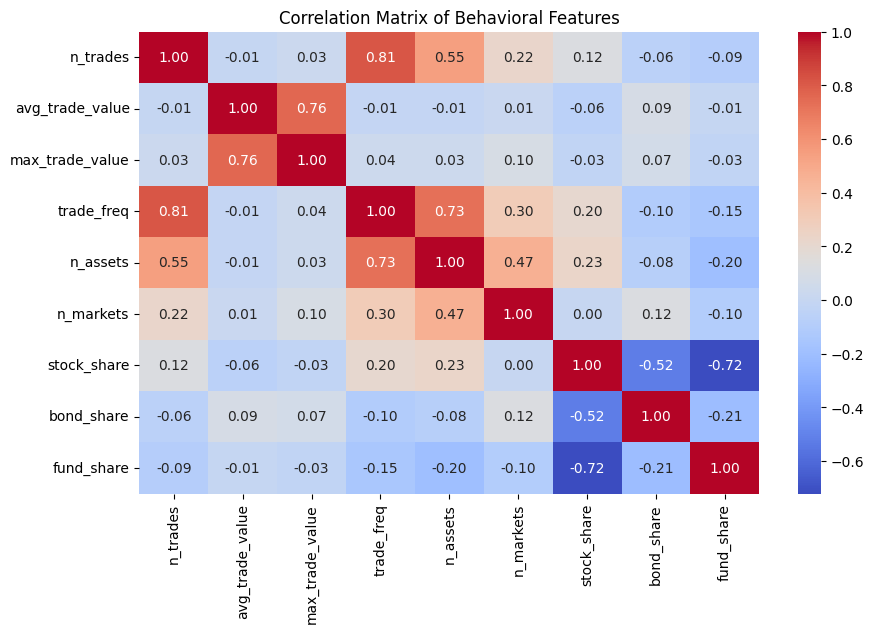

In [6]:
# Cell 4a — Correlation Heatmap of Engineered Features
plt.figure(figsize=(10,6))
corr = features.drop(columns=["customerID", "riskLevel_clean"]).corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Matrix of Behavioral Features")
plt.show()


📘 Explanation:

This heatmap shows how the engineered features relate to each other. Strong correlations may indicate redundancy (e.g., n_trades and trade_freq). Understanding this helps us decide which features are most informative for modeling.

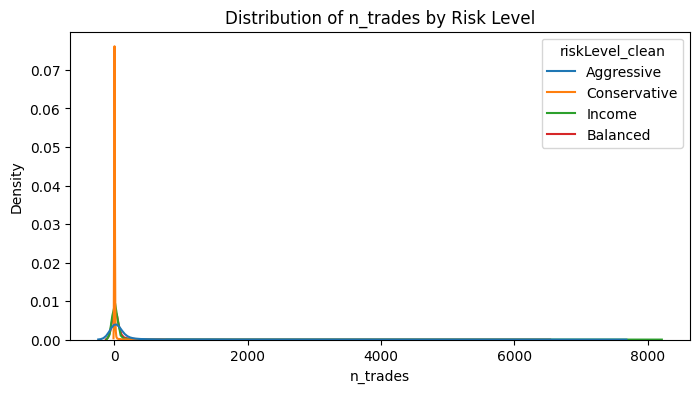

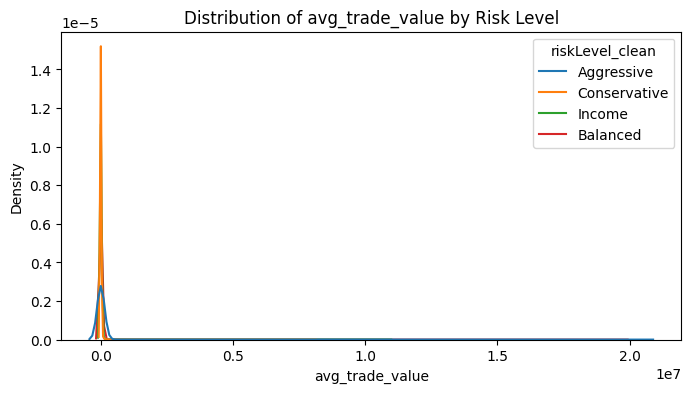

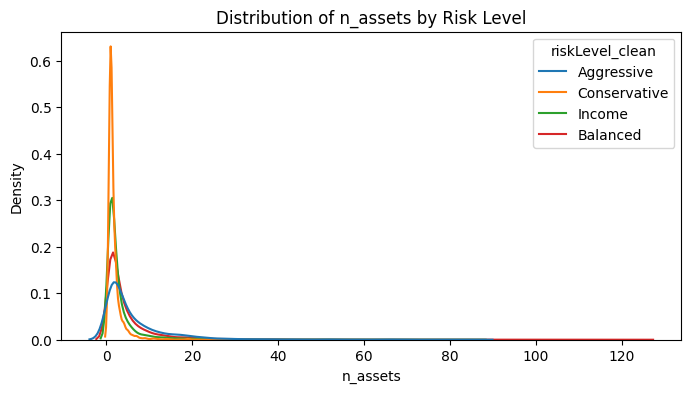

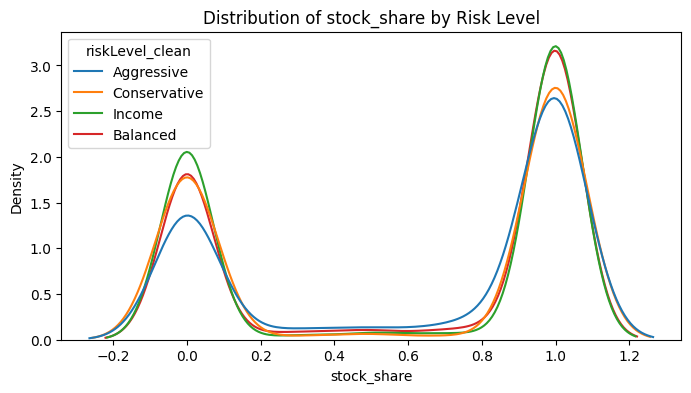

In [7]:
# Cell 4b — Distributions of key features per risk level
key_feats = ["n_trades", "avg_trade_value", "n_assets", "stock_share"]

for feat in key_feats:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=features, x=feat, hue="riskLevel_clean", common_norm=False)
    plt.title(f"Distribution of {feat} by Risk Level")
    plt.show()


📘 Explanation:

Distribution plots show how investors differ across risk levels. For example, Aggressive investors may cluster at higher stock allocations and higher trade volumes, while Conservative investors may show lower averages.

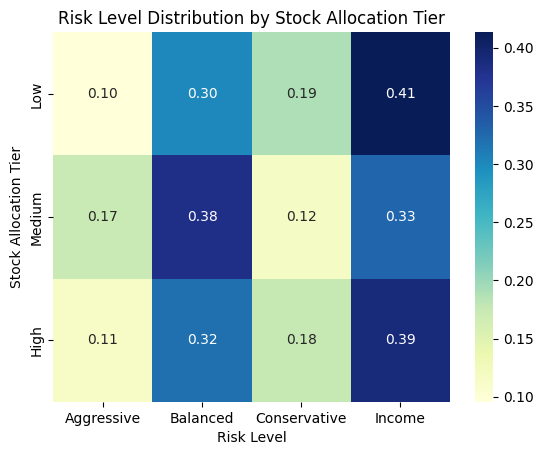

In [8]:
# Cell 4c — Risk Level Distribution by Stock Allocation Tier
portfolio_crosstab = pd.crosstab(
    pd.cut(features["stock_share"], bins=[-0.01, 0.33, 0.66, 1.0], labels=["Low", "Medium", "High"]),
    features["riskLevel_clean"],
    normalize="index"
)

sns.heatmap(portfolio_crosstab, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Risk Level Distribution by Stock Allocation Tier")
plt.xlabel("Risk Level")
plt.ylabel("Stock Allocation Tier")
plt.show()


📘 Explanation:

By binning stock allocation into Low, Medium, High, we can check how risk levels distribute across these tiers. Ideally, Aggressive investors should lean toward High stock exposure, while Conservative investors cluster in Low exposure.

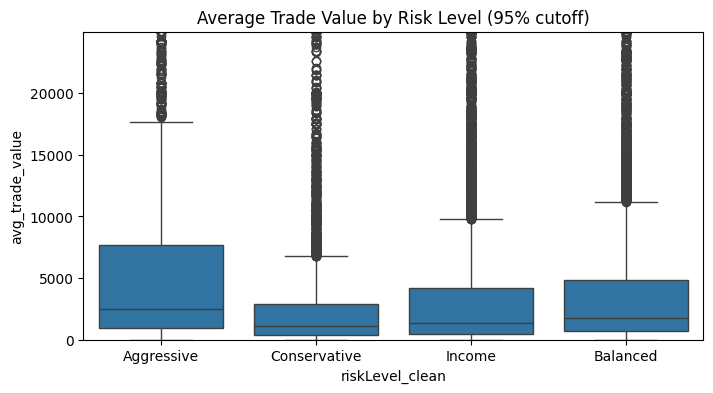

In [9]:
# Cell 4d — Outlier Inspection for Avg Trade Value
plt.figure(figsize=(8,4))
sns.boxplot(x="riskLevel_clean", y="avg_trade_value", data=features)
plt.ylim(0, np.percentile(features["avg_trade_value"], 95))  # trim top 5%
plt.title("Average Trade Value by Risk Level (95% cutoff)")
plt.show()


📘 Explanation:

Outliers (very large trades by a few customers) can distort averages. Trimming to the 95th percentile makes group differences clearer. For example, we may observe Aggressive investors typically making larger trades compared to others.

In [10]:
# Cell 5 — Save Enriched Dataset for Modeling
out_path = f"{PROC_DIR}/far_customers_features.csv"
features.to_csv(out_path, index=False)
print("💾 Saved enriched features at:", out_path)


💾 Saved enriched features at: /content/drive/MyDrive/portfoliai/data/processed/far_customers_features.csv


📘 Explanation:

We now save the feature-enriched customer dataset (far_customers_features.csv).
This file combines demographics, engineered behavioral features, and risk labels into a single table.

It will serve as the starting point for Notebook 4, where we retrain supervised models to test whether enriched features improve risk profile prediction.